In [4]:
pip install wfdb

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
#importing libraries
import time
import numpy as np
import wfdb
import ast
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl
from scipy.fftpack import fft, ifft
from scipy import signal


In [6]:
#Path Definition

path = 'h:\\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1\\'
sampling_rate = 500


In [7]:
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [8]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data


In [9]:
X = load_raw_data(Y, sampling_rate, path)


In [10]:
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)


In [11]:
agg_df = agg_df[agg_df.diagnostic == 1]


In [12]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))


In [13]:
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)


In [14]:
Y.columns


Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'diagnostic_superclass'],
      dtype='object')

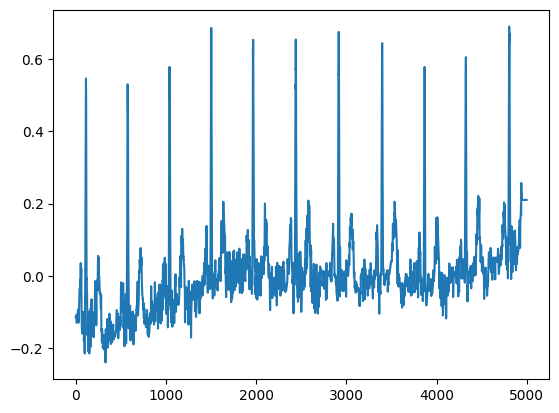

In [15]:
plt.plot(X[0][:,0])
plt.show()

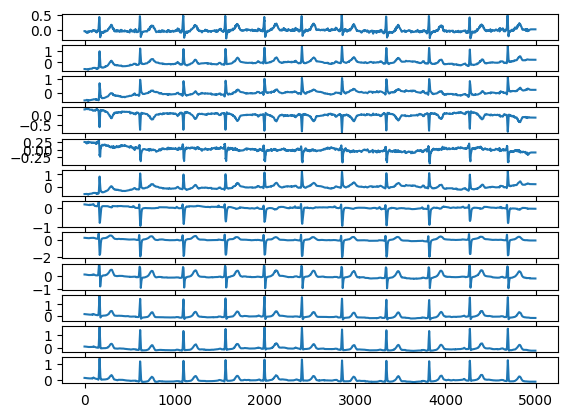

In [16]:
ecg = X[4]
plt.figure()
for index in range(12):
    plt.subplot(12,1,index+1)
    plt.plot(ecg[:,index])
plt.show()

In [17]:
def np_move_avg(a,n,mode="same"):
    return(np.convolve(a, np.ones((n,))/n, mode=mode))

In [18]:
ecg_original = X[np.random.randint(3096)][:,0]
ecg_filtered = np_move_avg(ecg_original, 5)

In [19]:
def ecg_fft_ana(ecg_original, sampling_rate):
    fs = sampling_rate
    ts = 1.0/fs
    t = np.arange(0, 1, ts)
    n = len(ecg_original)
    k = np.arange(n)
    t = n/fs,
    frq = k/t
    frq = frq[range(int(n/2))]
    fft_ecg = np.abs(fft(ecg_original))[range(int(n/2))]
    return frq, fft_ecg

In [20]:
def show_spec_dif(ecg_original, ecg_filtered, title1="title1", title2 = "title2"):
    frq, fft_ecg = ecg_fft_ana(ecg_original, sampling_rate)
    frq_filtered, fft_ecg_filtered = ecg_fft_ana(ecg_filtered, sampling_rate)
    plt.figure()
    plt.subplot(221)
    plt.plot(ecg_original[:500])
    plt.title(title1)
    plt.subplot(222)
    plt.plot(frq,fft_ecg)
    plt.title(title1 + '`s spectrum')
    plt.subplot(223)
    plt.plot(ecg_filtered[:500])
    plt.title(title2)
    plt.subplot(224)
    plt.plot(frq_filtered, fft_ecg_filtered)
    plt.title(title2 + '`s spectrum')
    plt.show()

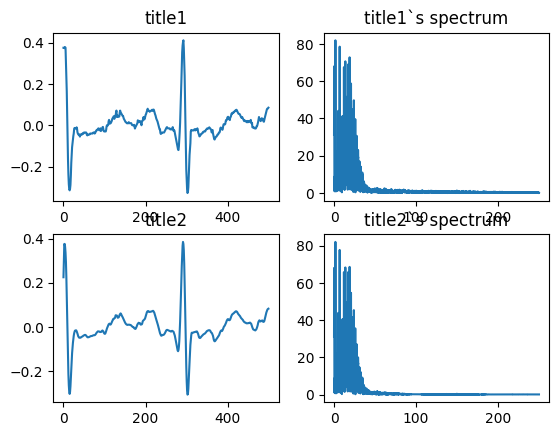

In [21]:
show_spec_dif(ecg_original, ecg_filtered)


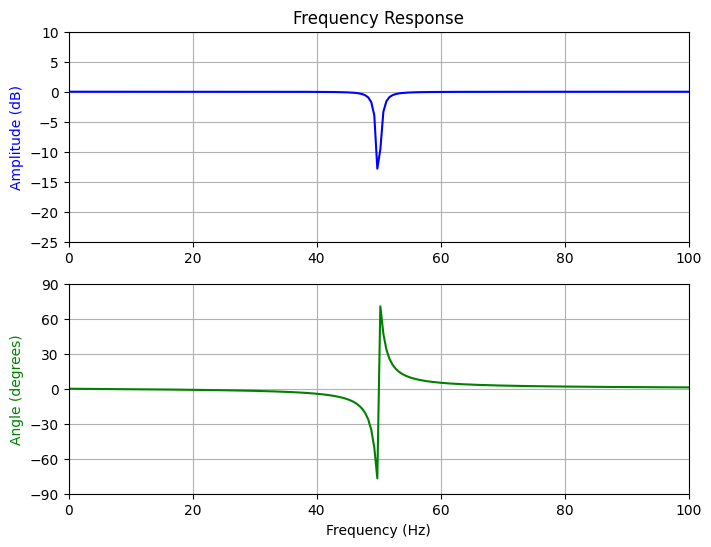

In [22]:
fs = sampling_rate  
f0 = 50.0   
Q = 30.0    
b, a = signal.iirnotch(f0, Q, fs)
freq, h = signal.freqz(b, a, fs=fs)
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
ax[0].plot(freq, 20*np.log10(abs(h)), color='blue')
ax[0].set_title("Frequency Response")
ax[0].set_ylabel("Amplitude (dB)", color='blue')
ax[0].set_xlim([0, 100])
ax[0].set_ylim([-25, 10])
ax[0].grid()
ax[1].plot(freq, np.unwrap(np.angle(h))*180/np.pi, color='green')
ax[1].set_ylabel("Angle (degrees)", color='green')
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_xlim([0, 100])
ax[1].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[1].set_ylim([-90, 90])
ax[1].grid()
plt.show()

In [23]:
ecg_notch = signal.filtfilt(b, a, ecg_filtered)

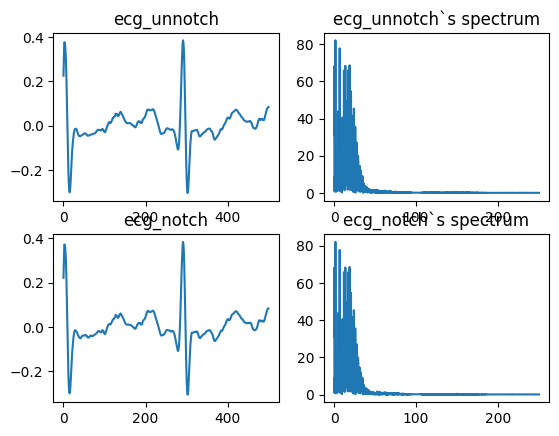

In [24]:
show_spec_dif(ecg_filtered, ecg_notch, "ecg_unnotch", "ecg_notch")


In [25]:
channels = 12
for index in range(len(X)):
    for channel in range(channels):
        X[index][:, channel] = np_move_avg(X[index][:, channel], 5)

In [26]:
ecg = X[np.random.randint(len(X))][:,1]

In [27]:
def get_diff(ecg):
    ecg_diff = np.zeros(len(ecg))
    for i in range(len(ecg)-1):
        ecg_diff[i] = ecg[i+1] - ecg[i]
    ecg_diff[len(ecg)-1] = ecg[len(ecg)-1]
    return ecg_diff

In [28]:
def checkR(ecg):
    max_val = np.max(ecg)
    min_val = np.min(ecg)
    threshold_val = (max_val-min_val)*0.7 + min_val
    index = []
    for i in range(1, len(ecg)-2):
        if ecg[i] == np.max(ecg[i-1:i+2]) and ecg[i] > threshold_val:
            if index != []:
                if i-index[-1] <= 60.0/60.0*sampling_rate and i-index[-1] >= 60.0/160.0*sampling_rate:
                    index.append(i)
            else:
                index.append(i)
    return np.array(index)

In [29]:
index = checkR(ecg)


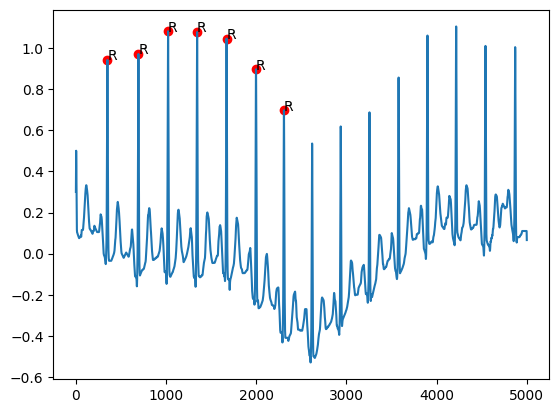

In [30]:
plt.figure()
plt.plot(ecg)
for i in range(len(index)):
    plt.scatter(index[i], ecg[index[i]],c='r')
    plt.annotate('R',(index[i], ecg[index[i]]))
plt.show()

In [31]:
def splitByR(ecg):
    index = checkR(ecg)
    ecg_rhythms = []  # Use a list to accumulate slices
    for i in range(len(index)):
        if index[i] > 200 and index[i] < len(ecg) - 350:  # Adjusted to use len(ecg) for flexibility
            ecg_rhythms.append(ecg[index[i]-150:index[i]+350])

    return ecg_rhythms


In [32]:
ecg_rhythm = splitByR(ecg)


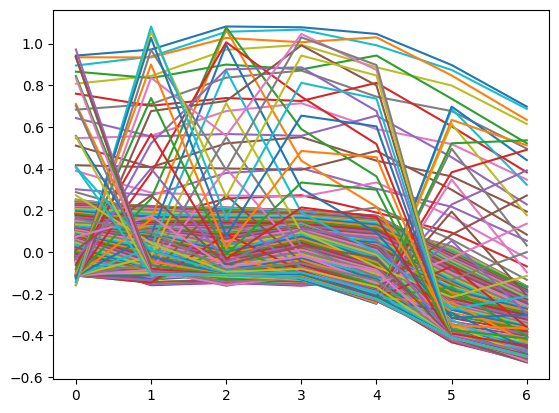

In [33]:

plt.figure()
plt.plot(ecg_rhythm)
plt.show()

In [34]:
channels = 12
test_size = len(X)
ecg_rhythms = np.zeros([test_size, 500, 12])

start_time = time.time()
first_time = start_time
for index in range(test_size):
    if index%1000 == 0:
        end_time = time.time()
        print("finish %d in %d s\n" % (index, end_time - start_time))
        start_time = time.time()
    R_index = checkR(X[index][:,1])
    for i in range(len(R_index)):
        # 提取出一段
        if R_index[i]>200 and R_index[i]<1000-350:
            ecg_rhythms[index][:, :] = X[index][R_index[i]-150:R_index[i]+350,:]
            continue

end_time = time.time()

print('time cost:%d s'%(end_time-first_time))


finish 0 in 0 s

finish 1000 in 49 s

finish 2000 in 57 s

finish 3000 in 58 s

finish 4000 in 48 s

finish 5000 in 48 s

finish 6000 in 41 s

finish 7000 in 29 s

finish 8000 in 29 s

finish 9000 in 29 s

finish 10000 in 30 s

finish 11000 in 29 s

finish 12000 in 30 s

finish 13000 in 28 s

finish 14000 in 28 s

finish 15000 in 30 s

finish 16000 in 30 s

finish 17000 in 30 s

finish 18000 in 30 s

finish 19000 in 49 s

finish 20000 in 51 s

finish 21000 in 50 s

time cost:857 s


In [35]:
ecg_rhythms.shape


(21837, 500, 12)

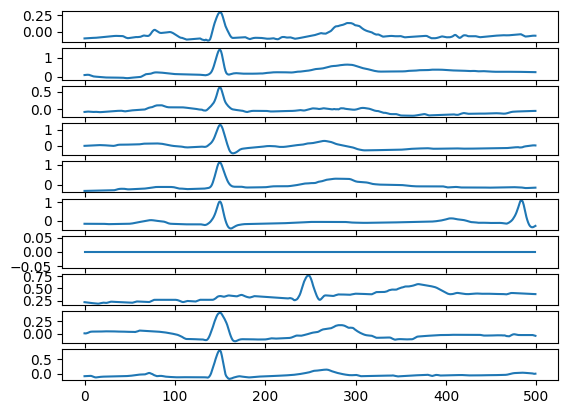

In [36]:
plt.figure()
for i in range(10):
    plt.subplot(10, 1, i+1)
    plt.plot(ecg_rhythms[i][:,1])
plt.show()

In [37]:
false_count = 0
Y['Runconfirmed'] = 0
for index in range(len(ecg_rhythms)):
    if ecg_rhythms[index].any() == np.zeros([500, 12]).any():
        false_count += 1
        Y['Runconfirmed'][index] = 1
false_count

C:\Users\AHAN\AppData\Local\Temp\ipykernel_18636\2216112086.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Y['Runconfirmed'][index] = 1
C:\Users\AHAN\AppData\Local\Temp\ipykernel_18636\2216112086.py:6: SettingWithCopyWarning: 
A value i

2598

In [38]:
# Split data into train and test
test_fold = 10
# Train
X_train = X[(Y.strat_fold != test_fold)&(Y.Runconfirmed !=1)]
y_train = Y[(Y.strat_fold != test_fold)&(Y.Runconfirmed !=1)].diagnostic_superclass
# Test
X_test = X[(Y.strat_fold == test_fold)&(Y.Runconfirmed !=1)]
y_test = Y[(Y.strat_fold == test_fold)&(Y.Runconfirmed !=1)].diagnostic_superclass

In [39]:
save_path = 'h:\\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1\\'
np.save(save_path+'X_train.npy', X_train)
np.save(save_path+'y_train.npy', y_train)
np.save(save_path+'X_test.npy', X_test)
np.save(save_path+'y_test.npy', y_test)